# Using "method chains" to create more readable code

### Game of Thrones example - slicing, group stats, and plotting

I didn't find an off the shelf dataset to run our seminal analysis from last week, but I found [an analysis](https://www.kaggle.com/dhanushkishore/impact-of-game-of-thrones-on-us-baby-names) that explored if Game of Thrones prompted parents to start naming their children differently. The following is inspired by that, but uses pandas to acquire and wrangle our data in a "Tidyverse"-style (how R would do it) flow.


In [7]:
#TO USE datadotworld PACKAGE:
#1. create account at data.world, then run the next two lines:
#2. in terminal/powershell: pip install datadotworld[pandas]
#
#   IF THIS DOESN'T WORK BC YOU GET AN ERROR ABOUT "CCHARDET", RUN:
#    conda install -c conda-forge cchardet
#   THEN RERUN: pip install datadotworld[pandas] 
#
#3. in terminal/powershell: dw configure          
#3a. copy in API token from data.world (get from settings > advanced)

import datadotworld as dw
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

baby_names = dw.load_dataset('nkrishnaswami/us-ssa-baby-names-national')
baby_names = baby_names.dataframes['names_ranks_counts']

#### Version 1
1. save a slice of the dataset with the names we want (using `.loc`)
2. sometimes a name is used by boys and girls in the same year, so combine the counts so that we have one observation per name per year
3. save the dataset and then call a plot function


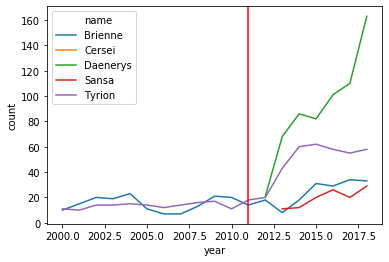

In [8]:
# restrict by name and only keep years after 2000
somenames = baby_names.loc[( # formating inside this () is just to make it clearer to a reader
    ( # condition 1: one of these names, | means "or"
        (baby_names['name'] == "Sansa") | (baby_names['name'] == "Daenerys") | 
        (baby_names['name'] == "Brienne") | (baby_names['name'] == "Cersei") | (baby_names['name'] == "Tyrion") 
    ) # end condition 1
    & # & means "and"
    ( # condition 2: these years
        baby_names['year'] >= 2000) # end condition 2
    )]

# if a name is used by F and M in a given year, combine the count variable
# Q: why is there a "reset_index"? 
# A: groupby automatically turns the groups (here name and year) into the index
#    reset_index makes the index simple integers 0, 1, 2 and also
#    turns the the grouping variables back into normal columns
# A2: instead of reset_index, you can include `as_index=False` inside groupby!
#     (I just learned that myself!)
somenames_agg = somenames.groupby(['name','year'])['count'].sum().reset_index().sort_values(['name','year'])

# plot
sns.lineplot(data=somenames_agg, hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted


#### Version 2 - `query` > `loc`, for readability
Same as V1, but step 1 uses `.query` to slice inside of `.loc`
1. save a slice of the dataset with the names we want (using `.query`)
2. sometimes a name is used by boys and girls in the same year, so combine the counts so that we have one observation per name per year
3. save the dataset and then call a plot function

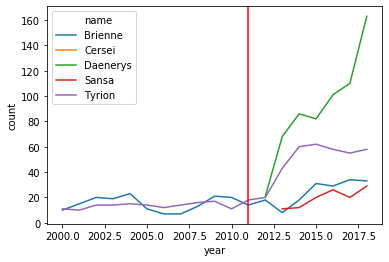

In [9]:
# use query instead to slice, and the rest is the same
somenames = baby_names.query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & \
         year >= 2000') # this is one string with ' as the string start/end symbol. Inside, I can use 
                        # normal quote marks for strings. Also, I can break it into multiple lines with \
somenames_agg = somenames.groupby(['name','year'])['count'].sum().reset_index().sort_values(['name','year'])
sns.lineplot(data=somenames_agg, hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted


#### Version 3 - Method chaining!
Method chaining: Call the object (`baby_names`) and then keep calling one method on it after another. 
- Python will call the methods from left to right. 
- There is no need to store the intermediate dataset (like `somenames` and `somenames_agg` above!)
    - --> Easier to read and write without "temp" objects all over the place
    - You can always save the dataset at an intermediate step if you need to

So, the first two steps are the same, just the methods will be chained. And then, a bonus trick to plot
without saving.
1. Slice with `.query` to GoT-related names
2. Combine M and F gender counts if a name is used by both in the same year
3. Plot without saving: "Pipe" in the plotting function 

The code below produces a plot identical to V1 and V2, **but it is unreadable. Don't try - I'm about to make this readable!** Just _one more_ iteration... 


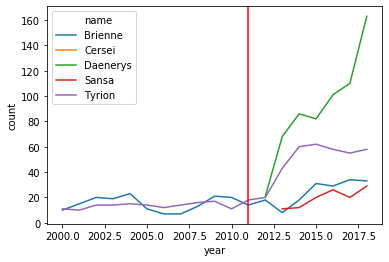

In [10]:
baby_names.query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & year >= 2000').groupby(['name','year'])['count'].sum().reset_index().pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted

To make this readable, we write a parentheses over multiple lines
```
(
    and python knows to execute the code inside as one line
)
```

And as a result, we can write a long series of methods that is comprehensible, and if we want we can even comment on each line:

Text(0.5, 1.0, 'WOW THAT WAS EASY TO WRITE AND SHARE')

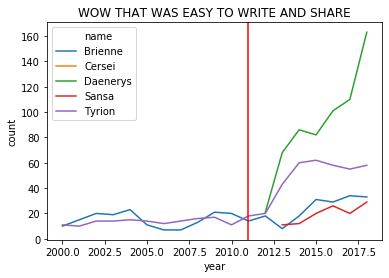

In [11]:
(baby_names
      .query('name in ["Sansa","Daenerys","Brienne","Cersei","Tyrion"] & \
         year >= 2000')
      .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
      .reset_index() # give us the column names back as they were (makes the plot call easy)
      .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
plt.title("WOW THAT WAS EASY TO WRITE AND SHARE")

**WOW. That's nice code!**


Also: **Naming your baby Daenerys after the hero...**

...is a bad break. 

Text(0.5, 1.0, 'PEOPLE NAMED THEIR KID KHALEESI')

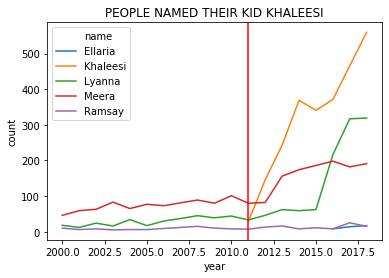

In [12]:
(baby_names
      .query('name in ["Khaleesi","Ramsay","Lyanna","Ellaria","Meera"] & \
         year >= 2000')
      .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
      .reset_index() # give use the column names back as they were (makes the plot call easy)
      .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.axvline(2011, 0,160,color='red') # add a line for when the show debuted
plt.title("PEOPLE NAMED THEIR KID KHALEESI")


**BUT IT COULD BE WORSE**

Text(0.5, 1.0, 'Alabama, wow...Krymson, really?')

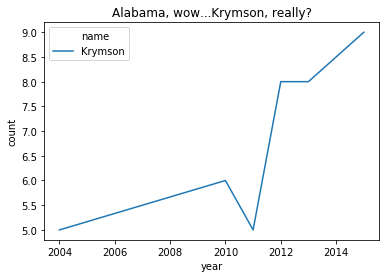

In [13]:
(baby_names
      .query('name in ["Krymson"] & year >= 1950')
      .groupby(['name','year'])['count'].sum() # for each name-year, combine M and F counts
      .reset_index() # give use the column names back as they were (makes the plot call easy)
      .pipe((sns.lineplot, 'data'),hue='name',x='year',y='count')
)    
plt.title("Alabama, wow...Krymson, really?")